In [2]:
##################################################################################################
# Patch-based Classification of Breast Cancer Histology Images using CNNs
# LE48: MiniProject
# Jan Ondras (jo356), Trinity College
# 2017/2018
##################################################################################################
# just corrected reshaping ,,... gives same results , have to correct for max islan and sum island

####################################################################################################
# TESTING THE BEST MODEL, all 4 voting schemes, 3 types of test set (most recent)
# only for original test set
####################################################################################################

####################################################################################################
# Load model for testing
####################################################################################################

from keras.models import load_model

# test_model_name = './../Model/SN_512_256_8_00/SN_512_256_8_00_w-17-0.20-0.93-1.78-0.65.hdf5'

# test_model_name = '/home/janciovec/Desktop/Model/SN_512_256_x00_w-43-0.58-0.77-1.04-0.64.hdf5'

# test_model_name = '/home/janciovec/Desktop/Model/SN_512_256_x00_w-50-0.74-0.70-1.01-0.63.hdf5'
test_model_name = './../Model/SN_512_256_x00/SN_512_256_x00_w-50-0.74-0.70-1.01-0.63.hdf5'
# 77.8 on maxprob

# test_model_name = '/home/janciovec/Desktop/Model/SN_512_256_xxx_w-50-0.54-0.79-1.04-0.66.hdf5'
# bad results ...
# test_model_name = '/home/janciovec/Desktop/Model/SN_512_256_x00_w-52-0.55-0.78-1.05-0.63.hdf5'


model = load_model(test_model_name)
print model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 84, 84, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 82, 82, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 41, 41, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 41, 41, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 20, 64)        36928     
__________

In [1]:
##################################################################################################
# Show model & save as figure
##################################################################################################
# Show model: https://keras.io/visualization/

#################################################
# Tofile
from keras.utils import plot_model
plot_model(model, to_file='model_ ' + test_model_name.split('/')[-1][:-5] + '.png', 
           show_shapes=True, show_layer_names=True)

#################################################
# Inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

Using TensorFlow backend.


NameError: name 'model' is not defined

In [3]:
####################################################################################################
# Predict on Test set
####################################################################################################

from sklearn.metrics import recall_score, accuracy_score, confusion_matrix
import sys
# import tifffile as tiff
import os
import numpy as np
# from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2
import glob
from keras.preprocessing import image
from keras.utils import to_categorical

####################################################################################################

RGB_means = [
    180.375933345 , 148.276127037 , 174.592562423
] 
# AWS: 180.375933345 , 148.276127037 , 174.592562423
# HPC: 180.7795009644826 , 148.3537065177495 , 174.59451631969864

# Image size (assume same for all images)
img_width =  2048
img_height = 1536
pix_scale = 0.42 # micrometers

target_size = (256, 256)
    
# Create patches
patch_width = 512                # DON'T CHANGE
patch_height = patch_width
patch_stride = 256 # 512 ? try
N_patches_x = (((img_width - patch_width) / patch_stride) + 1)
N_patches_y = (((img_height - patch_height) / patch_stride) + 1)
N_patches_per_img = N_patches_x * N_patches_y
print "Number of patches per image: ", N_patches_per_img, " = ", N_patches_x, " x ", N_patches_y

true_labels = np.concatenate( (np.repeat(0, 5), np.repeat(1, 5), np.repeat(2, 5), np.repeat(3, 5), 
                               np.repeat(0, 4), np.repeat(1, 4), np.repeat(2, 4), np.repeat(3, 4)))
N_test_imgs = len(true_labels)

print "#test images =", N_test_imgs
print "True labels = ", true_labels

path_prefix = './../Dataset/ICIAR2018_BACH_Challenge/Test_org_SN/'

classes = ['Normal', 'Benign', 'InSitu', 'Invasive'] # the same order as labels 0,1,2,3

PREDICTIONS = np.zeros( (N_test_imgs, N_patches_per_img, len(classes)) )

def substract_mean(patch):
    # RGB
    patch[:,:,0] -= RGB_means[0]
    patch[:,:,1] -= RGB_means[1]
    patch[:,:,2] -= RGB_means[2]
    return patch

# Iterate over test images
for img_name in glob.glob(path_prefix + '*.tif'): # can be any order, predictions are saved using indexing
#     print img_name
    img = image.img_to_array(image.load_img(img_name)) # RGB channel order
    imgID = int((img_name.split('/')[-1]).split('.')[-2])
#     print imgID
    true_img_label = true_labels[imgID] # true label for this image is: true_labels[imgID]
    
    # Split into patches
    for i in range(N_patches_x):
        for j in range(N_patches_y):
            patch = img[j*patch_stride:j*patch_stride + patch_height, i*patch_stride:i*patch_stride + patch_width, :]
            patch_resized = cv2.resize(patch, target_size, interpolation=cv2.INTER_NEAREST)  # resize patch to target_size
            ms_patch = substract_mean(patch_resized)   # mean substraction
            rs_ms_patch = np.reshape(ms_patch, [1,target_size[0],target_size[1],3]) # reshape
            
            PREDICTIONS[imgID, i*N_patches_y + j] = model.predict_proba(rs_ms_patch)[0]
            

Number of patches per image:  35  =  7  x  5
#test images = 36
True labels =  [0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]



Dataset type:  Initial

Patch-wise:
------------------------------------------------------------------------------

	Accuracy =  0.672857142857
	Sensitivity (recall) =  [ 0.67428571  0.66285714  0.65714286  0.69714286]
[[118  48   8   1]
 [  3 116  37  19]
 [  3  51 115   6]
 [  3  30  20 122]]
Normalized confusion matrix
[[ 0.67428571  0.27428571  0.04571429  0.00571429]
 [ 0.01714286  0.66285714  0.21142857  0.10857143]
 [ 0.01714286  0.29142857  0.65714286  0.03428571]
 [ 0.01714286  0.17142857  0.11428571  0.69714286]]


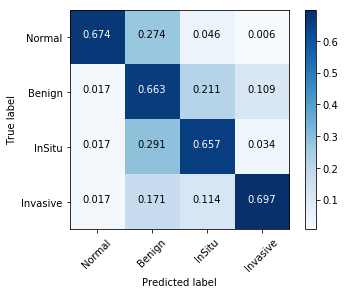


Image-wise:
------------------------------------------------------------------------------

Voting scheme: MAJORITY
	Accuracy =  0.8
	Sensitivity (recall) =  [ 0.8  1.   0.8  0.6]
	2 classes: non-carcinoma:  1.0  	 carcinoma:  0.8 ;	 => mean: 0.9
	2 classes: non-Invasive:  1.0  	 Invasive:  0.6
[[4 1 0 0]
 [0 5 0 0]
 [0 1 4 0]
 [0 1 1 3]]
Normalized confusion matrix
[[ 0.8  0.2  0.   0. ]
 [ 0.   1.   0.   0. ]
 [ 0.   0.2  0.8  0. ]
 [ 0.   0.2  0.2  0.6]]


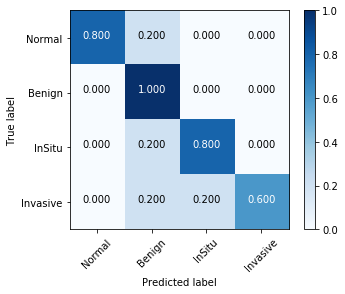

Voting scheme: MAX PROB
	Accuracy =  0.8
	Sensitivity (recall) =  [ 0.8  1.   0.6  0.8]
	2 classes: non-carcinoma:  1.0  	 carcinoma:  0.7 ;	 => mean: 0.85
	2 classes: non-Invasive:  1.0  	 Invasive:  0.8
[[4 1 0 0]
 [0 5 0 0]
 [0 2 3 0]
 [0 1 0 4]]
Normalized confusion matrix
[[ 0.8  0.2  0.   0. ]
 [ 0.   1.   0.   0. ]
 [ 0.   0.4  0.6  0. ]
 [ 0.   0.2  0.   0.8]]


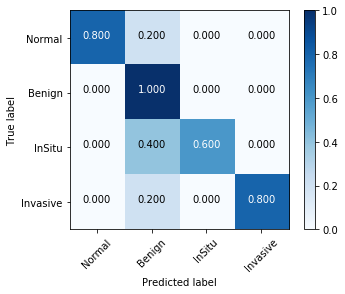

Voting scheme: SUM PROB
	Accuracy =  0.8
	Sensitivity (recall) =  [ 0.8  1.   0.8  0.6]
	2 classes: non-carcinoma:  1.0  	 carcinoma:  0.8 ;	 => mean: 0.9
	2 classes: non-Invasive:  1.0  	 Invasive:  0.6
[[4 1 0 0]
 [0 5 0 0]
 [0 1 4 0]
 [0 1 1 3]]
Normalized confusion matrix
[[ 0.8  0.2  0.   0. ]
 [ 0.   1.   0.   0. ]
 [ 0.   0.2  0.8  0. ]
 [ 0.   0.2  0.2  0.6]]


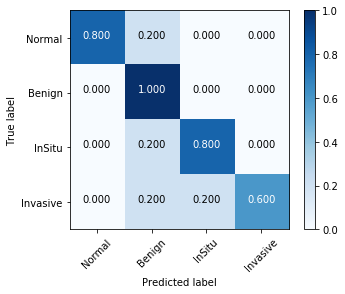

Voting scheme: SPAT CONS
	Accuracy =  0.8
	Sensitivity (recall) =  [ 0.8  1.   0.8  0.6]
	2 classes: non-carcinoma:  1.0  	 carcinoma:  0.8 ;	 => mean: 0.9
	2 classes: non-Invasive:  1.0  	 Invasive:  0.6
[[4 1 0 0]
 [0 5 0 0]
 [0 1 4 0]
 [0 1 1 3]]
Normalized confusion matrix
[[ 0.8  0.2  0.   0. ]
 [ 0.   1.   0.   0. ]
 [ 0.   0.2  0.8  0. ]
 [ 0.   0.2  0.2  0.6]]


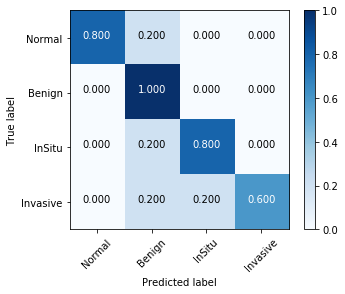

Voting scheme: MAX ISLAND
	Accuracy =  0.8
	Sensitivity (recall) =  [ 0.8  1.   0.8  0.6]
	2 classes: non-carcinoma:  1.0  	 carcinoma:  0.8 ;	 => mean: 0.9
	2 classes: non-Invasive:  1.0  	 Invasive:  0.6
[[4 1 0 0]
 [0 5 0 0]
 [0 1 4 0]
 [0 1 1 3]]
Normalized confusion matrix
[[ 0.8  0.2  0.   0. ]
 [ 0.   1.   0.   0. ]
 [ 0.   0.2  0.8  0. ]
 [ 0.   0.2  0.2  0.6]]


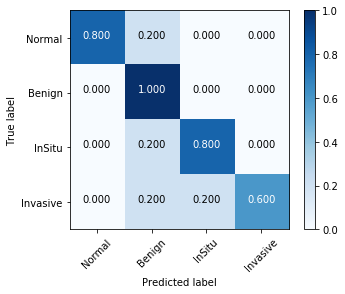


Dataset type:  Extended

Patch-wise:
------------------------------------------------------------------------------

	Accuracy =  0.514285714286
	Sensitivity (recall) =  [ 0.42857143  0.61428571  0.43571429  0.57857143]
[[60 46 26  8]
 [26 86  9 19]
 [45 28 61  6]
 [10 40  9 81]]
Normalized confusion matrix
[[ 0.42857143  0.32857143  0.18571429  0.05714286]
 [ 0.18571429  0.61428571  0.06428571  0.13571429]
 [ 0.32142857  0.2         0.43571429  0.04285714]
 [ 0.07142857  0.28571429  0.06428571  0.57857143]]


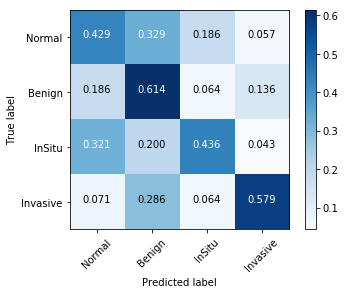


Image-wise:
------------------------------------------------------------------------------

Voting scheme: MAJORITY
	Accuracy =  0.5625
	Sensitivity (recall) =  [ 0.5   0.75  0.25  0.75]
	2 classes: non-carcinoma:  0.875  	 carcinoma:  0.5 ;	 => mean: 0.6875
	2 classes: non-Invasive:  0.916666666667  	 Invasive:  0.75
[[2 2 0 0]
 [0 3 0 1]
 [2 1 1 0]
 [0 1 0 3]]
Normalized confusion matrix
[[ 0.5   0.5   0.    0.  ]
 [ 0.    0.75  0.    0.25]
 [ 0.5   0.25  0.25  0.  ]
 [ 0.    0.25  0.    0.75]]


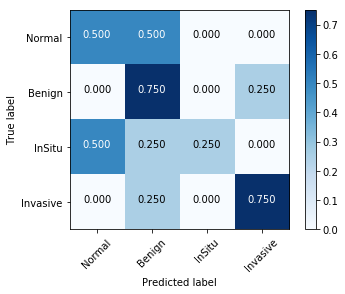

Voting scheme: MAX PROB
	Accuracy =  0.75
	Sensitivity (recall) =  [ 1.    0.5   0.75  0.75]
	2 classes: non-carcinoma:  0.75  	 carcinoma:  0.75 ;	 => mean: 0.75
	2 classes: non-Invasive:  0.916666666667  	 Invasive:  0.75
[[4 0 0 0]
 [0 2 1 1]
 [1 0 3 0]
 [0 1 0 3]]
Normalized confusion matrix
[[ 1.    0.    0.    0.  ]
 [ 0.    0.5   0.25  0.25]
 [ 0.25  0.    0.75  0.  ]
 [ 0.    0.25  0.    0.75]]


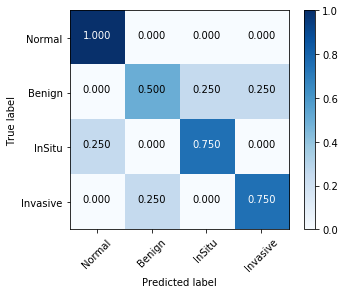

Voting scheme: SUM PROB
	Accuracy =  0.625
	Sensitivity (recall) =  [ 0.75  0.75  0.25  0.75]
	2 classes: non-carcinoma:  0.875  	 carcinoma:  0.5 ;	 => mean: 0.6875
	2 classes: non-Invasive:  0.916666666667  	 Invasive:  0.75
[[3 1 0 0]
 [0 3 0 1]
 [2 1 1 0]
 [0 1 0 3]]
Normalized confusion matrix
[[ 0.75  0.25  0.    0.  ]
 [ 0.    0.75  0.    0.25]
 [ 0.5   0.25  0.25  0.  ]
 [ 0.    0.25  0.    0.75]]


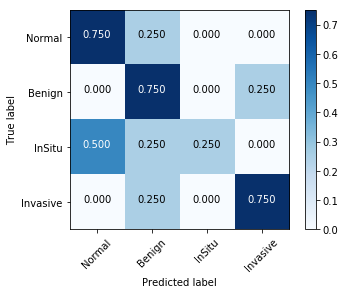

Voting scheme: SPAT CONS
	Accuracy =  0.5625
	Sensitivity (recall) =  [ 0.5   0.75  0.25  0.75]
	2 classes: non-carcinoma:  0.875  	 carcinoma:  0.5 ;	 => mean: 0.6875
	2 classes: non-Invasive:  0.916666666667  	 Invasive:  0.75
[[2 2 0 0]
 [0 3 0 1]
 [2 1 1 0]
 [0 1 0 3]]
Normalized confusion matrix
[[ 0.5   0.5   0.    0.  ]
 [ 0.    0.75  0.    0.25]
 [ 0.5   0.25  0.25  0.  ]
 [ 0.    0.25  0.    0.75]]


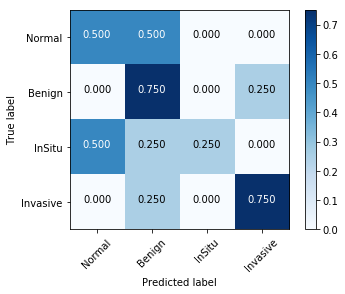

Voting scheme: MAX ISLAND
	Accuracy =  0.5625
	Sensitivity (recall) =  [ 0.5   0.75  0.25  0.75]
	2 classes: non-carcinoma:  0.875  	 carcinoma:  0.5 ;	 => mean: 0.6875
	2 classes: non-Invasive:  0.916666666667  	 Invasive:  0.75
[[2 2 0 0]
 [0 3 0 1]
 [2 1 1 0]
 [0 1 0 3]]
Normalized confusion matrix
[[ 0.5   0.5   0.    0.  ]
 [ 0.    0.75  0.    0.25]
 [ 0.5   0.25  0.25  0.  ]
 [ 0.    0.25  0.    0.75]]


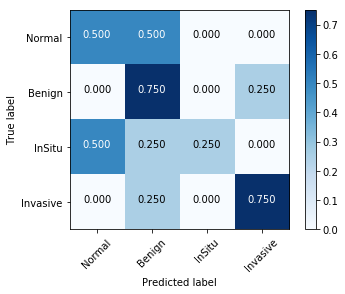


Dataset type:  Overall

Patch-wise:
------------------------------------------------------------------------------

	Accuracy =  0.602380952381
	Sensitivity (recall) =  [ 0.56507937  0.64126984  0.55873016  0.64444444]
[[178  94  34   9]
 [ 29 202  46  38]
 [ 48  79 176  12]
 [ 13  70  29 203]]
Normalized confusion matrix
[[ 0.56507937  0.2984127   0.10793651  0.02857143]
 [ 0.09206349  0.64126984  0.14603175  0.12063492]
 [ 0.15238095  0.25079365  0.55873016  0.03809524]
 [ 0.04126984  0.22222222  0.09206349  0.64444444]]


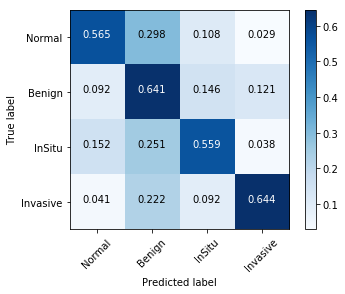


Image-wise:
------------------------------------------------------------------------------

Voting scheme: MAJORITY
	Accuracy =  0.694444444444
	Sensitivity (recall) =  [ 0.66666667  0.88888889  0.55555556  0.66666667]
	2 classes: non-carcinoma:  0.944444444444  	 carcinoma:  0.666666666667 ;	 => mean: 0.805555555556
	2 classes: non-Invasive:  0.962962962963  	 Invasive:  0.666666666667
[[6 3 0 0]
 [0 8 0 1]
 [2 2 5 0]
 [0 2 1 6]]
Normalized confusion matrix
[[ 0.66666667  0.33333333  0.          0.        ]
 [ 0.          0.88888889  0.          0.11111111]
 [ 0.22222222  0.22222222  0.55555556  0.        ]
 [ 0.          0.22222222  0.11111111  0.66666667]]


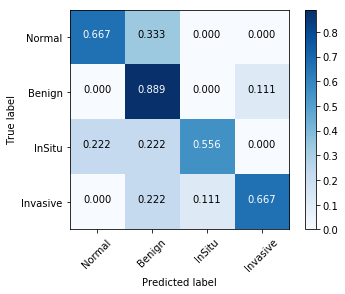

Voting scheme: MAX PROB
	Accuracy =  0.777777777778
	Sensitivity (recall) =  [ 0.88888889  0.77777778  0.66666667  0.77777778]
	2 classes: non-carcinoma:  0.888888888889  	 carcinoma:  0.722222222222 ;	 => mean: 0.805555555556
	2 classes: non-Invasive:  0.962962962963  	 Invasive:  0.777777777778
[[8 1 0 0]
 [0 7 1 1]
 [1 2 6 0]
 [0 2 0 7]]
Normalized confusion matrix
[[ 0.88888889  0.11111111  0.          0.        ]
 [ 0.          0.77777778  0.11111111  0.11111111]
 [ 0.11111111  0.22222222  0.66666667  0.        ]
 [ 0.          0.22222222  0.          0.77777778]]


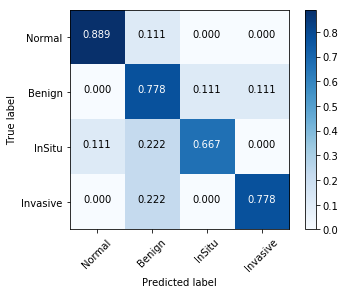

Voting scheme: SUM PROB
	Accuracy =  0.722222222222
	Sensitivity (recall) =  [ 0.77777778  0.88888889  0.55555556  0.66666667]
	2 classes: non-carcinoma:  0.944444444444  	 carcinoma:  0.666666666667 ;	 => mean: 0.805555555556
	2 classes: non-Invasive:  0.962962962963  	 Invasive:  0.666666666667
[[7 2 0 0]
 [0 8 0 1]
 [2 2 5 0]
 [0 2 1 6]]
Normalized confusion matrix
[[ 0.77777778  0.22222222  0.          0.        ]
 [ 0.          0.88888889  0.          0.11111111]
 [ 0.22222222  0.22222222  0.55555556  0.        ]
 [ 0.          0.22222222  0.11111111  0.66666667]]


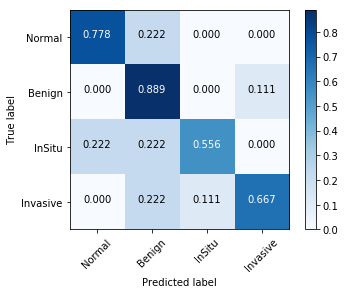

Voting scheme: SPAT CONS
	Accuracy =  0.694444444444
	Sensitivity (recall) =  [ 0.66666667  0.88888889  0.55555556  0.66666667]
	2 classes: non-carcinoma:  0.944444444444  	 carcinoma:  0.666666666667 ;	 => mean: 0.805555555556
	2 classes: non-Invasive:  0.962962962963  	 Invasive:  0.666666666667
[[6 3 0 0]
 [0 8 0 1]
 [2 2 5 0]
 [0 2 1 6]]
Normalized confusion matrix
[[ 0.66666667  0.33333333  0.          0.        ]
 [ 0.          0.88888889  0.          0.11111111]
 [ 0.22222222  0.22222222  0.55555556  0.        ]
 [ 0.          0.22222222  0.11111111  0.66666667]]


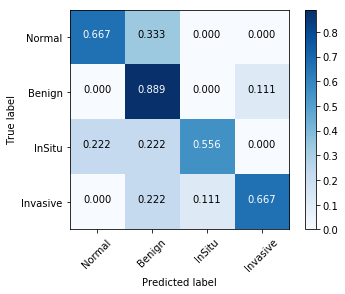

Voting scheme: MAX ISLAND
	Accuracy =  0.694444444444
	Sensitivity (recall) =  [ 0.66666667  0.88888889  0.55555556  0.66666667]
	2 classes: non-carcinoma:  0.944444444444  	 carcinoma:  0.666666666667 ;	 => mean: 0.805555555556
	2 classes: non-Invasive:  0.962962962963  	 Invasive:  0.666666666667
[[6 3 0 0]
 [0 8 0 1]
 [2 2 5 0]
 [0 2 1 6]]
Normalized confusion matrix
[[ 0.66666667  0.33333333  0.          0.        ]
 [ 0.          0.88888889  0.          0.11111111]
 [ 0.22222222  0.22222222  0.55555556  0.        ]
 [ 0.          0.22222222  0.11111111  0.66666667]]


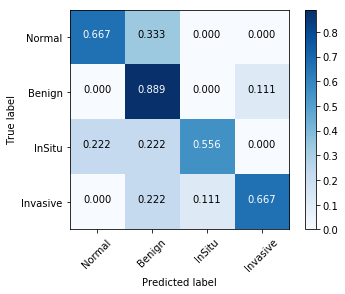

In [6]:
# From gathered predicitons calculated metrics for various voting schemes and datasets

voting_schemes = ['majority', 'maxprobab', 'sumprobab', 'spatialconsist']

from sklearn.metrics import confusion_matrix
# def maxAreaOfIsland(grid): # only 4 directions ...
#     seen = set()
#     def area(r, c):
#         if not (0 <= r < len(grid) and 0 <= c < len(grid[0])
#                 and (r, c) not in seen and grid[r][c]):
#             return 0
#         seen.add((r, c))
#         return (1 + area(r+1, c) + area(r-1, c) +
#                 area(r, c-1) + area(r, c+1))

#     return max(area(r, c)
#                for r in range(len(grid))
#                for c in range(len(grid[0])))

def maxAreaOfIsland(grid): # COUNTING ALL 8 directions ...
    seen = set()
    ans = 0
    for r0, row in enumerate(grid):
        for c0, val in enumerate(row):
            if val and (r0, c0) not in seen:
                shape = 0
                stack = [(r0, c0)]
                seen.add((r0, c0))
                while stack:
                    r, c = stack.pop()
                    shape += 1
                    for nr, nc in ((r-1, c), (r+1, c), (r, c-1), (r, c+1), 
                                  (r-1, c-1), (r+1, c+1), (r+1, c-1), (r-1, c+1) ):
                        if (0 <= nr < len(grid) and 0 <= nc < len(grid[0])
                                and grid[nr][nc] and (nr, nc) not in seen):
                            stack.append((nr, nc))
                            seen.add((nr, nc))
                ans = max(ans, shape)
    return ans

def maxPROB_OfIsland(grid, probs_grid): # COUNTING ALL 8 directions ...
    I_areas = []
    I_maxProbs = []
    seen = set()
    ans = 0.
    for r0, row in enumerate(grid):
        for c0, val in enumerate(row):
            if val and (r0, c0) not in seen:
                shape = 0. ######################## area zero
                I_MP = probs_grid[r0, c0] ### max is current
                stack = [(r0, c0)]
                seen.add((r0, c0))
                while stack:
                    r, c = stack.pop()
                    shape += 1 #################### adding area
                    I_MP = max(I_MP, probs_grid[r, c])  ### update maximum prob
                    for nr, nc in ((r-1, c), (r+1, c), (r, c-1), (r, c+1), 
                                  (r-1, c-1), (r+1, c+1), (r+1, c-1), (r-1, c+1) ):
                        if (0 <= nr < len(grid) and 0 <= nc < len(grid[0])
                                and grid[nr][nc] and (nr, nc) not in seen):
                            stack.append((nr, nc))
                            seen.add((nr, nc))
                I_areas.append(shape)
                I_maxProbs.append(I_MP)
                #ans = max(ans, shape) ###################### take max sofar
    if len(I_areas) == 0:
        return 0.
    return I_maxProbs[np.argmax( I_areas )]
#     return ans

def sumPROB_OfIsland(grid, probs_grid): # COUNTING ALL 8 directions ...
    I_areas = []
    I_sumProbs = []
    seen = set()
    ans = 0.
    for r0, row in enumerate(grid):
        for c0, val in enumerate(row):
            if val and (r0, c0) not in seen:
                shape = 0. ######################## area zero
                I_SP = probs_grid[r0, c0] ### sum is current
                stack = [(r0, c0)]
                seen.add((r0, c0))
                while stack:
                    r, c = stack.pop()
                    shape += 1 #################### adding area
                    I_SP += probs_grid[r, c]  ### update sum prob
                    for nr, nc in ((r-1, c), (r+1, c), (r, c-1), (r, c+1), 
                                  (r-1, c-1), (r+1, c+1), (r+1, c-1), (r-1, c+1) ):
                        if (0 <= nr < len(grid) and 0 <= nc < len(grid[0])
                                and grid[nr][nc] and (nr, nc) not in seen):
                            stack.append((nr, nc))
                            seen.add((nr, nc))
                I_areas.append(shape)
                I_sumProbs.append(I_SP)
                #ans = max(ans, shape) ###################### take max sofar
    if len(I_areas) == 0:
        return 0.          
    return I_sumProbs[np.argmax( I_areas )]


def p_argmax(a): # Priority based arg max function, to handle draws in correct order
    m = np.max(a)
    
    if a[3] == m: # Invasive
        return 3
    if a[2] == m: # InSitu
        return 2
    if a[1] == m: # Benign
        return 1
    if a[0] == m: # Normal
        return 0
    
import itertools
import matplotlib

def plot_cm(tl, pl):
    
    classesNames = classes
    #classesNames = ['N', 'B', 'S', 'I']
    if classesNames != classes:
        plt.figure(figsize=(3.,3.))
        rot = 0
    else:
        plt.figure()
        rot = 45
    
    cm = confusion_matrix(tl, pl) #.astype(np.float)
    print confusion_matrix(tl, pl)
    normalize = True
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#     plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classesNames, rotation=rot)
    plt.yticks(tick_marks, classesNames)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    
def get_2class_results(tl, ipl):
    cm = confusion_matrix(tl, ipl).astype(np.float)
    NONCARC = np.sum(cm[:2,:2])/np.sum(cm[:2,:])
    CARC = np.sum(cm[2:,2:])/np.sum(cm[2:,:])
    print "\t2 classes: non-carcinoma: ", NONCARC, " \t carcinoma: ", CARC, ";\t => mean:", np.mean([NONCARC, CARC]) 
    
    NONINV = np.sum(cm[:3,:3])/np.sum(cm[:3,:])
    INV = np.sum(cm[3:,3:])/np.sum(cm[3:,:])
    print "\t2 classes: non-Invasive: ", NONINV, " \t Invasive: ", INV
    
    plot_cm(tl, ipl)
    
    #     print cm, NONCARC, CARC, np.mean([NONCARC, CARC]) 

# print PREDICTIONS

# For every type of dataset
dataset_types = ['Initial', 'Extended', 'Overall']

for dt in dataset_types:
    print "\n=========================================================================================="
    print "Dataset type: ", dt
    print "==========================================================================================\n"
    
    if dt == 'Initial': # first 20
        P = PREDICTIONS[:20]
        TL = true_labels[:20]
    if dt == 'Extended': # last 16
        P = PREDICTIONS[20:]
        TL = true_labels[20:]
    if dt == 'Overall': # all 36
        P = PREDICTIONS
        TL = true_labels
#     print len(P) == len(TL), len(P)
    
    #########################################################################################
    #########################################################################################
    #########################################################################################
    # FOR PATCH-WISE: calculate accuracy/sesitivity 
    print "Patch-wise:\n------------------------------------------------------------------------------\n"
    PTL = np.repeat(TL, N_patches_per_img) # patch true labels
    PPL = [] # patch predicted labels
    for i in P:
        for p in i:
            PPL.append( p_argmax(p) )
    print "\tAccuracy = ", accuracy_score(PTL, PPL)
    print "\tSensitivity (recall) = ", recall_score(PTL, PPL, average=None)
    plot_cm(PTL, PPL)
    
    #########################################################################################
    #########################################################################################
    #########################################################################################
    # FOR IMAGE-WISE: for every voting scheme calculate accuracy/sesitivity 
    print "\nImage-wise:\n------------------------------------------------------------------------------\n"
    
    #########################################################################################
    print "Voting scheme: MAJORITY"

    IPL = []
    for i in P:
        v = np.zeros(4) # number of votes for each class        
        for p in i:
            v[ p_argmax(p) ] += 1
            
        IPL.append( p_argmax(v) )
#         IPL.append( p_argmax(v) )
    
    print "\tAccuracy = ", accuracy_score(TL, IPL)
    print "\tSensitivity (recall) = ", recall_score(TL, IPL, average=None)
    get_2class_results(TL, IPL)
    
    #########################################################################################
    print "Voting scheme: MAX PROB"

    IPL = []
    for i in P:
        IPL.append( p_argmax( np.max(i, axis=0) ) )
        
    print "\tAccuracy = ", accuracy_score(TL, IPL)
    print "\tSensitivity (recall) = ", recall_score(TL, IPL, average=None)
    get_2class_results(TL, IPL)
    
    #########################################################################################
    print "Voting scheme: SUM PROB"
    
    IPL = []
    for i in P:
        IPL.append( p_argmax( np.sum(i, axis=0) ) )
        
    print "\tAccuracy = ", accuracy_score(TL, IPL)
    print "\tSensitivity (recall) = ", recall_score(TL, IPL, average=None)
    get_2class_results(TL, IPL)
    
    #########################################################################################
    print "Voting scheme: SPAT CONS"

    IPL = []
    for img in P:
        pv = []   # patch votes
        v = np.zeros(4) # number of votes for each class  
        for p in img:
            v[ p_argmax(p) ] += 1
            pv.append( p_argmax(p) )
            
        # Iterate over matrix of patch votes and compute connections
        c = np.zeros(4) # number of connections for each class   
        #print pv
        #pv_mat = np.reshape(pv, (N_patches_y, N_patches_x)) 
        pv_mat = np.reshape(pv, (N_patches_x, N_patches_y))
        pv_mat = np.transpose(pv_mat, axes=(1,0))
#         print pv_mat

        for y in range(N_patches_y):
            for x in range(N_patches_x):
                con = 0. # number of shared labels with this patch (in its 1-step neighbourhood)
                
                for i in [-1,0,1]:
                    for j in [-1,0,1]:
#                         if i == j and i == -1:
#                             continue
#                         if i == j and i == 1:
#                             continue
                        #if i==j==0 ? connection with itself ?
                        if y == y+i and x == x+j:
                            continue
                        if ( y+i > -1 and y+i < N_patches_y and x+j > -1 and x+j < N_patches_x ): # check bounds
                            if pv_mat[y, x] == pv_mat[y+i, x+j]:
                                con += 1.
#                                 con += P[i, x*N_patches_y + y, pv_mat[y, x] ] 
                
                c[ pv_mat[y, x] ] += con # add # connections found
#         print c
#         print v
        IPL.append( p_argmax( v * c ) )
#         IPL.append( np.argmax( c ) )

    print "\tAccuracy = ", accuracy_score(TL, IPL)
    print "\tSensitivity (recall) = ", recall_score(TL, IPL, average=None)
    get_2class_results(TL, IPL)
    
    #########################################################################################
    print "Voting scheme: MAX ISLAND"

    IPL = []
    for img in P:
        pv = []   # patch votes
        v = np.zeros(4) # number of votes for each class  
        for p in img:
            v[ p_argmax(p) ] += 1
            pv.append( p_argmax(p) )
            
        # Iterate over matrix of patch votes and compute connections
        #pv_mat = np.reshape(pv, (N_patches_y, N_patches_x)) 
        pv_mat = np.reshape(pv, (N_patches_x, N_patches_y))
        pv_mat = np.transpose(pv_mat, axes=(1,0))
#         print pv_mat

        areas = np.zeros(4)
    
        pv_mat_0 = np.copy(pv_mat)
        for i in range(pv_mat_0.shape[0]):
            for j in range(pv_mat_0.shape[1]):
                if pv_mat_0[i,j] == 0:
                    pv_mat_0[i,j] = 1
                else:
                    pv_mat_0[i,j] = 0
                    
        areas[0] = maxAreaOfIsland(pv_mat_0)
#         print areas[0]
#         print pv_mat.
        pv_mat_1 = np.copy(pv_mat)
        for i in range(pv_mat_1.shape[0]):
            for j in range(pv_mat_1.shape[1]):
                if pv_mat_1[i,j] == 1:
                    pv_mat_1[i,j] = 1
                else:
                    pv_mat_1[i,j] = 0
                    
        areas[1] = maxAreaOfIsland(pv_mat_1)
        
        pv_mat_2 = np.copy(pv_mat)
        for i in range(pv_mat_2.shape[0]):
            for j in range(pv_mat_2.shape[1]):
                if pv_mat_2[i,j] == 2:
                    pv_mat_2[i,j] = 1
                else:
                    pv_mat_2[i,j] = 0
                    
        areas[2] = maxAreaOfIsland(pv_mat_2)
        
        pv_mat_3 = np.copy(pv_mat)
        for i in range(pv_mat_3.shape[0]):
            for j in range(pv_mat_3.shape[1]):
                if pv_mat_3[i,j] == 3:
                    pv_mat_3[i,j] = 1
                else:
                    pv_mat_3[i,j] = 0
                    
        areas[3] = maxAreaOfIsland(pv_mat_3)
                
    
        IPL.append( p_argmax( areas ) )
#         IPL.append( np.argmax( c ) )

    print "\tAccuracy = ", accuracy_score(TL, IPL)
    print "\tSensitivity (recall) = ", recall_score(TL, IPL, average=None)
    get_2class_results(TL, IPL)

#     #########################################################################################
#     print "Voting scheme: MAX PROB ISLAND"

#     IPL = []
#     for img in P:
#         pv = []   # patch votes
#         v = np.zeros(4) # number of votes for each class  
#         for p in img:
#             v[ p_argmax(p) ] += 1
#             pv.append( p_argmax(p) )
            
#         # Iterate over matrix of patch votes and compute connections
#         #pv_mat = np.reshape(pv, (N_patches_y, N_patches_x)) 
#         pv_mat = np.reshape(pv, (N_patches_x, N_patches_y))
#         pv_mat = np.transpose(pv_mat, axes=(1,0))
# #         print pv_mat

#         areas = np.zeros(4)
    
#         pv_mat_0 = np.copy(pv_mat)
#         for i in range(pv_mat_0.shape[0]):
#             for j in range(pv_mat_0.shape[1]):
#                 if pv_mat_0[i,j] == 0:
#                     pv_mat_0[i,j] = 1
#                 else:
#                     pv_mat_0[i,j] = 0
                                        
#         areas[0] = maxPROB_OfIsland(pv_mat_0, np.reshape(img[:,0], (N_patches_y, N_patches_x)) )
# #         print areas[0]
# #         print pv_mat.
#         pv_mat_1 = np.copy(pv_mat)
#         for i in range(pv_mat_1.shape[0]):
#             for j in range(pv_mat_1.shape[1]):
#                 if pv_mat_1[i,j] == 1:
#                     pv_mat_1[i,j] = 1
#                 else:
#                     pv_mat_1[i,j] = 0
                    
#         areas[1] = maxPROB_OfIsland(pv_mat_1, np.reshape(img[:,1], (N_patches_y, N_patches_x)) )
        
#         pv_mat_2 = np.copy(pv_mat)
#         for i in range(pv_mat_2.shape[0]):
#             for j in range(pv_mat_2.shape[1]):
#                 if pv_mat_2[i,j] == 2:
#                     pv_mat_2[i,j] = 1
#                 else:
#                     pv_mat_2[i,j] = 0
                    
#         areas[2] = maxPROB_OfIsland(pv_mat_2, np.reshape(img[:,2], (N_patches_y, N_patches_x)) )
        
#         pv_mat_3 = np.copy(pv_mat)
#         for i in range(pv_mat_3.shape[0]):
#             for j in range(pv_mat_3.shape[1]):
#                 if pv_mat_3[i,j] == 3:
#                     pv_mat_3[i,j] = 1
#                 else:
#                     pv_mat_3[i,j] = 0
                    
#         areas[3] = maxPROB_OfIsland(pv_mat_3, np.reshape(img[:,3], (N_patches_y, N_patches_x)) )
                
    
#         IPL.append( p_argmax( areas ) )
# #         IPL.append( np.argmax( c ) )

#     print "\tAccuracy = ", accuracy_score(TL, IPL)
#     print "\tSensitivity (recall) = ", recall_score(TL, IPL, average=None)
#     get_2class_results(TL, IPL)

#     #########################################################################################
#     print "Voting scheme: SUM PROB ISLAND"

#     IPL = []
#     for img in P:
#         pv = []   # patch votes
#         v = np.zeros(4) # number of votes for each class  
#         for p in img:
#             v[ p_argmax(p) ] += 1
#             pv.append( p_argmax(p) )
            
#         # Iterate over matrix of patch votes and compute connections
# #         pv_mat = np.reshape(pv, (N_patches_y, N_patches_x)) 
#         pv_mat = np.reshape(pv, (N_patches_x, N_patches_y))
#         pv_mat = np.transpose(pv_mat, axes=(1,0))
# #         print pv_mat

#         areas = np.zeros(4)
    
#         pv_mat_0 = np.copy(pv_mat)
#         for i in range(pv_mat_0.shape[0]):
#             for j in range(pv_mat_0.shape[1]):
#                 if pv_mat_0[i,j] == 0:
#                     pv_mat_0[i,j] = 1
#                 else:
#                     pv_mat_0[i,j] = 0
                    
#         areas[0] = sumPROB_OfIsland(pv_mat_0, np.reshape(img[:,0], (N_patches_y, N_patches_x)) )
# #         print areas[0]
# #         print pv_mat.
#         pv_mat_1 = np.copy(pv_mat)
#         for i in range(pv_mat_1.shape[0]):
#             for j in range(pv_mat_1.shape[1]):
#                 if pv_mat_1[i,j] == 1:
#                     pv_mat_1[i,j] = 1
#                 else:
#                     pv_mat_1[i,j] = 0
                    
#         areas[1] = sumPROB_OfIsland(pv_mat_1, np.reshape(img[:,1], (N_patches_y, N_patches_x)) )
        
#         pv_mat_2 = np.copy(pv_mat)
#         for i in range(pv_mat_2.shape[0]):
#             for j in range(pv_mat_2.shape[1]):
#                 if pv_mat_2[i,j] == 2:
#                     pv_mat_2[i,j] = 1
#                 else:
#                     pv_mat_2[i,j] = 0
                    
#         areas[2] = sumPROB_OfIsland(pv_mat_2, np.reshape(img[:,2], (N_patches_y, N_patches_x)) )
        
#         pv_mat_3 = np.copy(pv_mat)
#         for i in range(pv_mat_3.shape[0]):
#             for j in range(pv_mat_3.shape[1]):
#                 if pv_mat_3[i,j] == 3:
#                     pv_mat_3[i,j] = 1
#                 else:
#                     pv_mat_3[i,j] = 0
                    
#         areas[3] = sumPROB_OfIsland(pv_mat_3, np.reshape(img[:,3], (N_patches_y, N_patches_x)) )
                
    
#         IPL.append( p_argmax( areas ) )
# #         IPL.append( np.argmax( c ) )

#     print "\tAccuracy = ", accuracy_score(TL, IPL)
#     print "\tSensitivity (recall) = ", recall_score(TL, IPL, average=None)
#     get_2class_results(TL, IPL)
